# Tutorial

> Basic creation of circuits, protocols and usage of the direct Monte Carlo sampler

In this tutorial we take a look at a very basic usage example of a *Repeat-until-success* protocol to prepare the GHZ state $|GHZ\rangle=\frac{1}{\sqrt{2}}(|0000\rangle+|1111\rangle)$ on qubits 0-3. Qubit number 4 is a flag qubit which we measure as `0` if the preparation was successful, i.e. the GHZ-state has been prepared upto max. 1 error and `1` if the preparation was unsuccessful, i.e. the output state is erroneous by an error weight larger than 1. In this case we want to repeat the preparation for a maximium of 3 times. If for the 3rd iteration we measure again a `1` we want to count a **logical error**. The circuit looks like this:

In [ ]:
from qsam.circuit import Circuit

ghz = Circuit([ {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

Now we define the protocol. Note that **EXIT** marks a *significant* termination which we would like to count as a logical failure. If we measure the flag as `0` for some intermediate circuit the protocol terminates *insignificantly* which is not explicitly shown in the below graph. Also, note that **START** node must always be given and must always have a transition with `check=True` to *only a single node*. For the other nodes we can reference any prospective measurement result in the complete measurement history by using the node name in backticks, for example `` `ghz1` `` will be replaced with the measurement result of the execution of the circuit associated with node ghz1, which we can reference also for example for the `check` of ghz3, as the measurement of `ghz1` lies in its past. If a measurement at a certain point is not in the past of a node the part of the check expression containing this reference will automatically evaluate to `False`.

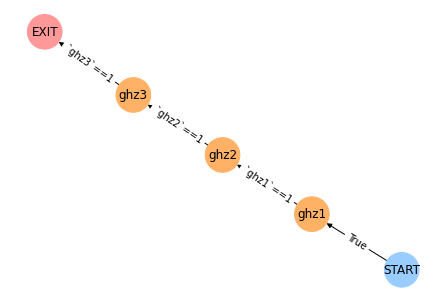

In [ ]:
from qsam.protocol import Protocol,draw_protocol

ghz3 = Protocol()
ghz3.add_nodes_from(['ghz1','ghz2','ghz3'], circuits=ghz)

ghz3.add_edge('START', 'ghz1', check='True')
ghz3.add_edge('ghz1', 'ghz2', check='`ghz1`==1')
ghz3.add_edge('ghz2', 'ghz3', check='`ghz2`==1')
ghz3.add_edge('ghz3', 'EXIT', check='`ghz3`==1')

draw_protocol(ghz3)

Now, we are ready to sample. Let's define some error parameters, instantiate a `Sampler` object and start sampling.

In [ ]:
from qsam.samplers import Sampler
import numpy as np

p_phy = np.logspace(-3,0,10)
err_params = {'p': p_phy}
sam = Sampler(ghz3, err_params)
p_L, std = sam.run(n_samples=30000)

Finally, plot the results as usual

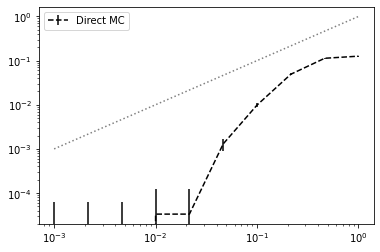

In [ ]:
import matplotlib.pyplot as plt

plt.errorbar(p_phy, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.plot(p_phy, p_phy, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

We can see that for large physical error rates the direct sampler performs good but gets worse for lower rates. In this region we benefit a lot by using the subset sampler.

In [ ]:
from qsam.samplers import SubsetSampler
import numpy as np

p_phy = np.logspace(-3,0,10)
err_params = {'p': p_phy}
sam = SubsetSampler(ghz3, err_params)
p_L_low, ss_std = sam.run(n_samples=3000, w_max=3)

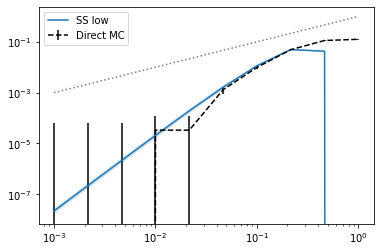

In [ ]:
import matplotlib.pyplot as plt

plt.errorbar(p_phy, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p_phy, p_L_low, label="SS low")
plt.fill_between(p_phy, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
# plt.plot(p, p_L_up, label="SS up")
# plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p_phy, p_phy, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();